In [1]:
#from spatial_metabolic_distribution import Maps, MetabolicPropertyMapsAssembler
from spectral_spatial_simulation import Model as SpectralSpatialModel
from spectral_spatial_simulation import FID
from sampling import Model as SamplingModel
from matplotlib.pyplot import legend, title
import matplotlib.pyplot as plt
from display import plot_FID
from easygraph import Graph
#from printer import Console
from prettyconsole import Console
import dask.array as da
import numpy as np
import cupy as cp
import os.path
import tools
import dask
import pint
import file
import h5py
import sys

from tqdm import tqdm
import warnings

# Both required for the JupyterPlotManager
from tools import JupyterPlotManager
%matplotlib ipympl

In [2]:
# Initialise the UnitRegistry
u = pint.UnitRegistry()

# Initialise the graph (visual representation)

In [3]:
g = Graph(measure_time=True)
g.add_cluster(name="Initial configuration")
g.add_cluster(name="Load and prepare the data")
g.add_cluster(name="Interpolation", supercluster="Load and prepare the data")
g.add_cluster(name="Create models")
g.add_cluster(name="GPU cluster")
g.add_cluster(name="k-space")

g.add_cluster(name="Forward Process")

# Check number of reserved CPUs and total available CPUs

In [4]:
print("available number of CPUs for this simulation (vary if reserved):")
!nproc

available number of CPUs for this simulation (vary if reserved):
40


In [5]:
print("all logical CPUs on the system:")
!nproc --all

all logical CPUs on the system:
40


# Check current GPU load & Define GPU(s) for small and big tasks

In [6]:
# Set generally visible GPU devices

!nvidia-smi

Wed Jan 21 14:45:45 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB           On  | 00000000:07:00.0 Off |                    0 |
| N/A   32C    P0              37W / 300W |     55MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

#target_gpu_smaller_tasks = 2
#target_gpus_big_tasks = [3]

target_gpu_smaller_tasks = 1
target_gpus_big_tasks = [1,2]

device_memory_limit = "32GB"

In [8]:
g.add_node(name="Target GPUs",
           text=f"Define GPU {target_gpus_big_tasks} for big tasks (limit={device_memory_limit}) and "
                f"GPU {target_gpu_smaller_tasks} for small tasks", 
           width=0.5, cluster="Initial configuration")

# Check free RAM

In [9]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           251Gi        13Gi       187Gi        18Mi        51Gi       236Gi
Swap:             0B          0B          0B


# <span style="color:red">Define Simulation paramaters (TODO collect all important ones)</span>

In [10]:
TE=0.0013
TR=0.6
alpha=45

# Load defined paths in the configurator

In [11]:
config_file_name = "paths_09012026.json"

g.add_node(name="Config file paths", 
           text=f"Using config file for providing paths: {config_file_name}",
           cluster="Initial configuration")

In [12]:
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

# Load metabolic mask

In [13]:
g.add_node(name="Load Metabolic Mask", 
           text="Load Metabolic Mask", 
           connect_from="Config file paths", cluster="Load and prepare the data")

metabolic_mask = file.Mask(configurator=configurator)
metabolic_mask.load(mask_name="metabolites")

[  1  ][ success ] ---v                       
                      Loaded file 'Vol_004_mask_slab.nii':
                          Shape             -> (112, 128, 80)
                          Pixel dimensions: -> (1.7188, 1.7188, 1.72)
                          Values range:     -> [0.0, 1.0]
                          In memory cache?  -> True
[  2  ][ success ] >> Thus, loaded the 'metabolites' mask                                                                  


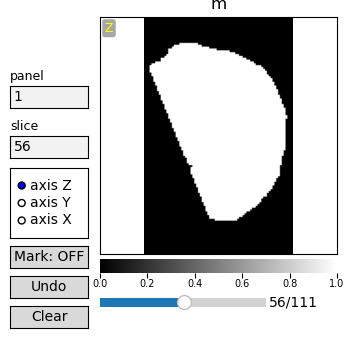

In [14]:
metabolic_mask.plot_jupyter()

# Load the FIDs

In [15]:
g.add_node(name="Load example FIDs", 
           connect_from="Config file paths", 
           cluster="Load and prepare the data")

metabolites = file.FID(configurator=configurator)
metabolites.load(fid_name="metabolites", signal_data_type=np.complex64)

[  3  ][  info   ] ---v                       
                      Loaded FID signal as <class 'numpy.complex64'> 
                       -> thus using space: 264.0 KB 
                       -> thus using digits: 15
[  4  ][ success ] >> Transformed FID signal to complex values: (16896, 2) -> (16896,)                                     
[  5  ][ success ] ---v  (collected several lines)                      
                      Assigned FID parts:
                      0. Acetyl+Aspartyl_moi(NAAG) -----> shape: (1536,)
                      1. Choline_moi(GPC) --------------> shape: (1536,)
                      2. Creatine (Cr) -----------------> shape: (1536,)
                      3. Glutamate (Glu) ---------------> shape: (1536,)
                      4. Glutamate_moi(NAAG) -----------> shape: (1536,)
                      5. Glutamine_noNH2 (Gln) ---------> shape: (1536,)
                      6. Glycerol_moi(GPC) -------------> shape: (1536,)
                      7. MyoIno

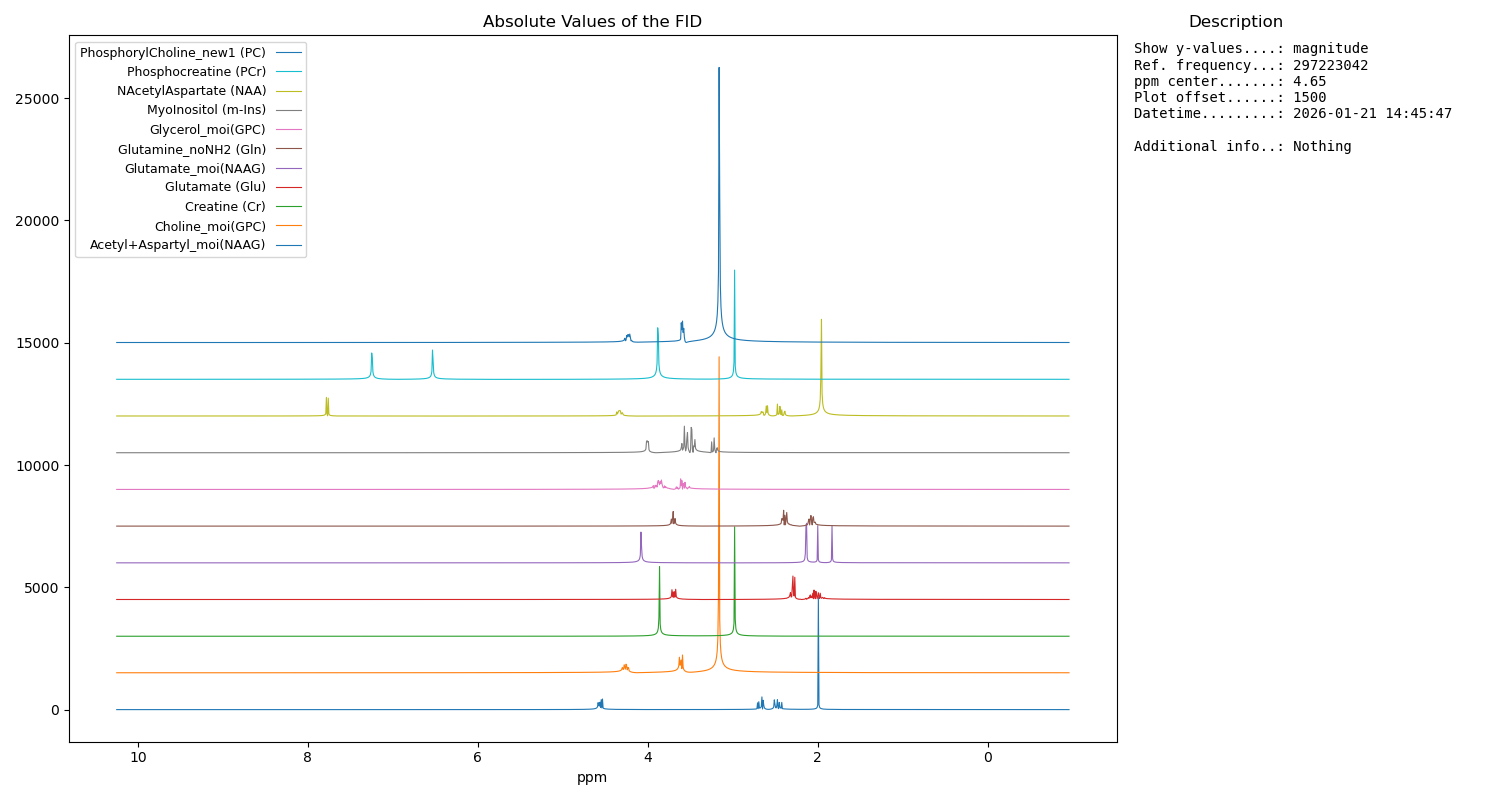

In [16]:
loaded_fid = metabolites.loaded_fid
loaded_fid.plot()

In [17]:
loaded_fid.name

['Acetyl+Aspartyl_moi(NAAG)',
 'Choline_moi(GPC)',
 'Creatine (Cr)',
 'Glutamate (Glu)',
 'Glutamate_moi(NAAG)',
 'Glutamine_noNH2 (Gln)',
 'Glycerol_moi(GPC)',
 'MyoInositol (m-Ins)',
 'NAcetylAspartate (NAA)',
 'Phosphocreatine (PCr)',
 'PhosphorylCholine_new1 (PC)']

# Load and prepare the concentration maps

In [18]:
text = """ =====================================================================================================
        Step: Load and prepare concentration maps 
        
        Description: ´Loading the concentration maps, assigning working names and interpolating it with 2nd order. 
                      Currently using: (a) Glu, (b) Gln, (c) m-Ins, (d) NAA, (e) Cr+PCr, (f) GPC+PCh´
        
                      [X] Simulated data is used
        """

g.add_node(name="Load and prepare concentration maps",
           text=text, 
           connect_from=["Load Metabolic Mask", "Load example FIDs"],
           width=1.05, 
           title_colour="green", 
           cluster="Load and prepare the data")

In [19]:
loaded_concentration_maps = file.Maps(configurator=configurator, map_type_name="metabolites_concentration")
working_name_and_file_name = {"Glu": "MetMap_Glu_con_map_TargetRes_HiRes.nii",
                              "Gln": "MetMap_Gln_con_map_TargetRes_HiRes.nii",
                              "m-Ins": "MetMap_Ins_con_map_TargetRes_HiRes.nii",
                              "NAA": "MetMap_NAA_con_map_TargetRes_HiRes.nii",
                              "Cr+PCr": "MetMap_Cr+PCr_con_map_TargetRes_HiRes.nii",
                              "GPC+PCh": "MetMap_GPC+PCh_con_map_TargetRes_HiRes.nii",
                             }
loaded_concentration_maps.load_files_from_folder(working_name_and_file_name=working_name_and_file_name)

[  6  ][  info   ] >> Maps object: The provided path points to a folder                                                    
[  7  ][ warning ] >> Maps.load_files_from_folder ==> by standard nii is loaded. No h5 support yet!                        
[  8  ][ warning ] >> The same unit is assumed for all the files in the given folder!                                      
[  9  ][ success ] ---v  (collected several lines)                      
                      Loaded maps: 
                        0: working name: .......Glu | Shape:   (440, 440, 266) | Values range: [0.0, 42.733] | Unit: millimole |
                        1: working name: .......Gln | Shape:   (440, 440, 266) | Values range: [0.0, 41.138] | Unit: millimole |
                        2: working name: .....m-Ins | Shape:   (440, 440, 266) | Values range: [0.0, 40.316] | Unit: millimole |
                        3: working name: .......NAA | Shape:   (440, 440, 266) | Values range: [0.0, 42.934] | Unit: millimole |
   

In [20]:
loaded_concentration_maps.to_base_units()
loaded_concentration_maps.to_parameter_volume(data_type="float32")

[ 10  ][ success ] >> Converted to base units: millimole -> mole                                                           


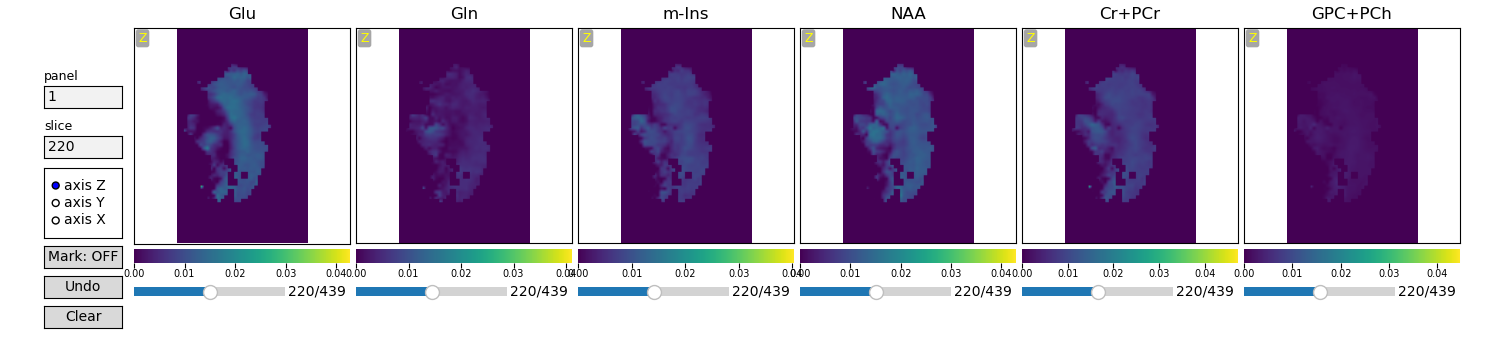

In [25]:
loaded_concentration_maps.plot_jupyter(cmap="viridis")

In [21]:
from spatial_metabolic_distribution import ParameterMap
#####
# NOW HERE LOADED MAPS TO WORKING MAPS:
# -> list(ParameterMap) -> tensor(list(ParameterMap)) -> thats it?
parameter_maps: list = []
for metabolite_name, values in loaded_concentration_maps.loaded_maps.items():
    parameter_maps.append(ParameterMap(map_type=loaded_concentration_maps.map_type_name, metabolite_name=metabolite_name, values=values, unit=loaded_concentration_maps.loaded_maps_unit))

In [22]:
print(parameter_maps[0])

[ 11  ][  info   ] ---v  (collected several lines)                      
                      The parameter map contains the following properties:
                       => map type: .......... metabolites_concentration
                       => metabolite: ........ Glu
                       => unit: .............. mole
                       => values shape: ...... (440, 440, 266)
                       => values data type: .. float64
                       => required space: .... 392.9 mebibyte (MiB)
                      




In [23]:
parameter_maps[0].map_type

'metabolites_concentration'

In [24]:
#from tools import SpaceEstimator
#SpaceEstimator.for_numpy(data, verbose=True) + SpaceEstimator.for_numpy(data, verbose=True) 

In [25]:
from spatial_metabolic_distribution import ParameterVolume

parameter_volume = ParameterVolume(maps_type="metabolites_concentration")

for p in parameter_maps:
    parameter_volume.add_map(p)

parameter_volume.to_volume()

[ 12  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... metabolites_concentration 
                       Unit: ........... mole 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Size: ........... 2357.4 mebibyte


In [26]:
parameter_volume.to_data_type("float32")

[ 13  ][ success ] >> Changed the data type from float64 (2357.4 mebibyte) -> float32 (1178.7 mebibyte)                    


In [28]:
print(parameter_volume)

[ 14  ][  info   ] ---v  (collected several lines)                      
                      The parameter map contains the following properties:
                       => maps type: ......... metabolites_concentration
                       => metabolites: ....... ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']
                       => unit: .............. mole
                       => values shape: ...... (6, 440, 440, 266)
                       => values data type: .. float32
                       => required space: .... 1178.7 mebibyte (MiB)
                      




In [21]:
loaded_concentration_maps.to_working_maps()

AttributeError: 'MetabolicPropertyMap' object has no attribute 'maps'

In [49]:

concentration_maps = Maps(loaded_concentration_maps.loaded_maps)
g.add_node(name="Interpolate concentration maps", text=f"Interpolate concentration maps to {metabolic_mask.shape}", cluster="Interpolation", width=0.5)
concentration_maps.interpolate_to_target_size(target_size=metabolic_mask.shape,
                                              order=2,
                                              target_device='cuda',
                                              target_gpu=target_gpu_smaller_tasks)

AttributeError: 'Mask' object has no attribute 'shape'

In [ ]:
###fig, axs = plt.subplots(figsize=(15,2), ncols=len(loaded_concentration_maps.loaded_maps.items()), nrows=1)
###
###imnage = None
###for i, (key, value) in enumerate(loaded_concentration_maps.loaded_maps.items()):
###    image = axs[i].imshow(value[:,:,40])
###    axs[i].set_title(key)
###    axs[i].set_axis_off()
###
###fig.colorbar(image, ax=axs, location="right")


fig, axs, state = JupyterPlotManager.volume_grid_viewer(
    loaded_concentration_maps.loaded_maps.values(),
    rows=1,
    cols=len(loaded_concentration_maps.loaded_maps.keys()),
    titles=loaded_concentration_maps.loaded_maps.keys(),
    cmap="viridis"
)

# Load and prepare the T1 maps
### <span style="color:red">!!! Only one T1 map is loaded at the moment and used for each metabolite.</span>

In [22]:
text = """ =====================================================================================================
        Step: Load and prepare the T1 maps
        
        Description: Only one T1 map is loaded at the moment and used for each metabolite.
        
            [ ] Use for each metabolite a corresponding T1 map.
            [ ] Scale map not manually below to [ms]
        
        Note: The same one T1 map is for each metabolite used!
        """
g.add_node(name="Load and prepare T1 maps",
           text=text, 
           cluster="Load and prepare the data",
           title_colour="yellow")

In [23]:
# Try to load it like I did it for concentration:
#loaded_T1_maps = file.Maps(configurator=configurator, map_type_name="metabolites_concentration")
#path_to_one_map

path_to_one_map = os.path.join(configurator.data["maps"]["metabolites_concentration"]["path"], "T1_TargetRes_HiRes.nii")
loaded_T1_map = file.NeuroImage(path=path_to_one_map).load_nii().data * 1e-3

XX = file.NeuroImage(path=path_to_one_map).load_nii()

[ 11  ][ success ] ---v                       
                      Loaded file 'T1_TargetRes_HiRes.nii':
                          Shape             -> (440, 440, 266)
                          Pixel dimensions: -> (0.5, 0.5, 0.5)
                          Values range:     -> [-327.493, 4848.004]
                          In memory cache?  -> True
[ 12  ][ success ] ---v                       
                      Loaded file 'T1_TargetRes_HiRes.nii':
                          Shape             -> (440, 440, 266)
                          Pixel dimensions: -> (0.5, 0.5, 0.5)
                          Values range:     -> [-327.493, 4848.004]
                          In memory cache?  -> True


In [24]:
loaded_T1_maps = file.Maps(configurator=configurator, map_type_name="T1")
loaded_T1_maps.load_file()

[ 13  ][  info   ] >> Maps object: The provided path points to a file                                                      
[ 14  ][  info   ] >> Loading nii file for map type T1                                                                     
[ 15  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: T1_TargetRes_HiRes.nii | Shape: (440, 440, 266) | Values range: [-327.493, 4848.004] | Unit: millisecond | Unique values: 888245
                      


In [25]:
data_ = loaded_T1_maps.loaded_maps
unit_ = loaded_T1_maps.loaded_maps_unit

from tools import UnitTools

#XX = UnitTools.to_SI(values=data_, unit=unit_, return_separate=True, verbose=True)

#def to_SI(values, unit=None)
#if isinstance(values, pint.Quantity):
#    quantity = values
#else:
#    quantity = Maps.u.Quantity(values, unit)
#
#quantity = quantity.to_base_units()
#values = quantity.magnitude
#unit = quantity.unit
#    
#    
#    X = loaded_T1_maps.u.Quantity(data_, unit_).to_base_units()
#    XX = loaded_T1_maps.u.Quantity(data_, unit_)
#type(unit_)
loaded_T1_maps.to_si_units()
#loaded_T1_maps.loaded_maps_unit

AttributeError: 'Maps' object has no attribute 'to_si_units'

In [ ]:
path_to_one_map = os.path.join(configurator.data["maps"]["metabolites_concentration"]["path"], "T1_TargetRes_HiRes.nii")
loaded_T1_map = file.NeuroImage(path=path_to_one_map).load_nii().data * 1e-3

working_name_and_map = {"Glu": loaded_T1_map,
                        "Gln": loaded_T1_map,
                        "m-Ins": loaded_T1_map,
                        "NAA": loaded_T1_map,
                        "Cr+PCr": loaded_T1_map,
                        "GPC+PCh": loaded_T1_map,
                       }
t1_maps = Maps(maps=working_name_and_map)
g.add_node(name="Interpolate T1", text=f"Interpolate T1 maps to {metabolic_mask.shape}", cluster="Interpolation", width=0.5)
t1_maps.interpolate_to_target_size(target_size=metabolic_mask.shape,
                                   order=2,
                                   target_device='cuda',
                                   target_gpu=target_gpu_smaller_tasks)

In [ ]:
###fig, axs = plt.subplots(figsize=(15,2), ncols=len(t1_maps.maps.items()), nrows=1)
###
###image = None
###for i, (key, value) in enumerate(t1_maps.maps.items()):
###    image = axs[i].imshow(value[:,:,40])
###    axs[i].set_axis_off()
###    axs[i].set_title(key)
###
###fig.colorbar(image, ax=axs, location="right")

fig, axs, state = JupyterPlotManager.volume_grid_viewer(
    t1_maps.maps.values(),
    rows=1,
    cols=len(t1_maps.maps.keys()),
    titles=t1_maps.maps.keys(),
    cmap="viridis"
)

In [ ]:
t1_maps.maps["Glu"][27,44,40]

# Load and prepare the T2 maps

In [26]:
text = """ =====================================================================================================
        Step: Load and prepare T2 maps
        
        ´Description: At the moment only placeholder data is used. Therefore, mean values of certain regions in brain 
                      from paper cited in the code.´
            
            [X] Using literature values at the first step: random values from distribution exhibiting mu and sigma.
            [ ] Check if T2 and T2* correctly applied in code!
            [X] Using T2 and T2* values from literature
            [ ] Using a T2 and T2* map for each metabolite
        """
g.add_node(name="Load and prepare T2 maps", text=text, cluster="Load and prepare the data", title_colour="red")

#### <span style="color:red">!!! The reference where T2 vales ares used from:</span>

In [27]:
## Using T2* values from:
#cm = tools.CitationManager("../docs/references.bib")
#cm.cite("peters2007t2") # Paper offers Grey Matter (GM), White matter (WM), Caudate, Putamen T2* values in [ms];
#                        # However, using naive approach for first step: (GM+WM)/2 and also the scattering of
#                        # values (33.2+26.8)/2 +/- (1.3+1.2)/2 ==> 30 +/- 1.25
# mu=30*1e-3
# sigma=1.25*1e-3

# Using T2 values from:
cm = tools.CitationManager("../docs/references.bib")
cm.cite("versteeg2024high")
# But also see:
cm.cite("seginer2022phase")

t2_GM_WM_average = (((25+39)/2) + ((33+55)/2))/2

In [28]:
#working_name_and_map = {"Glu":      np.random.normal(loc=mu, scale=sigma, size=metabolic_mask.data.shape),
#                        "Gln":      np.random.normal(loc=mu, scale=sigma, size=metabolic_mask.data.shape),
#                        "m-Ins":    np.random.normal(loc=mu, scale=sigma, size=metabolic_mask.data.shape),
#                        "NAA":      np.random.normal(loc=mu, scale=sigma, size=metabolic_mask.data.shape),
#                        "Cr+PCr":   np.random.normal(loc=mu, scale=sigma, size=metabolic_mask.data.shape),
#                        "GPC+PCh":  np.random.normal(loc=mu, scale=sigma, size=metabolic_mask.data.shape),
#                       }


working_name_and_map = {"Glu":      np.full(metabolic_mask.data.shape, t2_GM_WM_average),
                        "Gln":      np.full(metabolic_mask.data.shape, t2_GM_WM_average),
                        "m-Ins":    np.full(metabolic_mask.data.shape, t2_GM_WM_average),
                        "NAA":      np.full(metabolic_mask.data.shape, t2_GM_WM_average),
                        "Cr+PCr":   np.full(metabolic_mask.data.shape, t2_GM_WM_average),
                        "GPC+PCh":  np.full(metabolic_mask.data.shape, t2_GM_WM_average),
                       }

t2_maps = Maps(maps=working_name_and_map)
g.add_node(name="Interpolate T2", text=f"Interpolate T2 maps to {metabolic_mask.shape}", cluster="Interpolation", width=0.5)
t2_maps.interpolate_to_target_size(target_size=metabolic_mask.shape,
                                   order=2,
                                   target_device='cuda',
                                   target_gpu=target_gpu_smaller_tasks)

AttributeError: 'Mask' object has no attribute 'data'

In [ ]:
fig, axs = plt.subplots(figsize=(15,2), ncols=len(t2_maps.maps.items()), nrows=1)

image = None

for i, (key, value) in enumerate(t2_maps.maps.items()):
    image = axs[i].imshow(value[:,:,40])
    axs[i].set_axis_off()
    axs[i].set_title(key)

#fig.colorbar(image, ax=axs, location="right")

# Use desired FID signals and merge some of them

In [ ]:
text = """ =====================================================================================================
        Step: Partially FID
        
        ´Description: Take a subset of all desired signals of the FID. Some signals need to be combined individually by
                      adding them and dividing it then by a certain factor.´
        
            [X] Combine Creatine ( Cr ) and Phosphocreatine ( PCr ) -> Cr+PCr (divisor = 2)
           ´[X] Combine Choline_moi( GPC ) and Glycerol_moi( GPC ) and PhosphorylCholine_new1 ( PC ) -> GPC+PCh 
                (divisor = 2)´
        """
g.add_node(name="Partially FID", text=text, cluster="Load and prepare the data",title_colour="green", width=1.1)

using_fid_signals = ["Glutamate (Glu)",
                     "Glutamine_noNH2 (Gln)",
                     "MyoInositol (m-Ins)",
                     "NAcetylAspartate (NAA)",
                     "Creatine (Cr)",
                     "Phosphocreatine (PCr)",
                     "Choline_moi(GPC)",
                     "Glycerol_moi(GPC)",
                     "PhosphorylCholine_new1 (PC)"]

In [ ]:
# Take a subset of all signals of the FID. This returns a new FID object.
fid = loaded_fid.get_partly_fid(using_fid_signals)

# Merge signals of the FID in order to match the Maps
fid.merge_signals(names=["Creatine (Cr)", "Phosphocreatine (PCr)"],
                  new_name="Cr+PCr",
                  divisor=2)

fid.merge_signals(names=["Choline_moi(GPC)", "Glycerol_moi(GPC)", "PhosphorylCholine_new1 (PC)"],
                  new_name="GPC+PCh",
                  divisor=2)

fid.name = fid.get_name_abbreviation()

In [ ]:
concentration_maps
t1_maps
t2_maps

# TODO: Transform file.Maps to 


#

# * Not better to combine this maps like this: concentration maps + t1 maps + t2 maps   __add__ --> then need sorting algorithm?
#    --> class MetabolicPropertyMap
#        either add maps as input or add with +

# * and in file Maps or spatial metabolic distribution Maps add the units?
# * Then, assemble options still in the class

# Create Metabolic Property Maps

In [31]:
block_size = (int(35), int(112), int(128), int(80))
#block_size = (int(20), int(112//3), int(128//3), int(80//3))
#block_size = (int(20), int(56), int(64), int(40))
text = f""" =====================================================================================================
        Step: Create Metabolic Property Maps

        ´Description: Create dictionary of Metabolic Property Maps, where each contains the T1 map, T2 map, 
        concentration map of the respective metabolite.
        Using dask block size: {block_size}´

        [ ] Print number of blocks and memory used per block
        [ ] Ok to work with units programmatically? E.g. here for concentration mmol, T1 and T2 ms.
        
        Note: Try blocksize (5, 56, 64, 40) for 100.000 FID points.

        """
g.add_node(name="Create Metabolic Property Maps", text=text, cluster="Create models", title_colour="yellow")

assembler = MetabolicPropertyMapsAssembler(#block_size=(block_size[1], block_size[2], block_size[3]), # Not longer supported!!!
                                           concentration_maps=concentration_maps,
                                           t1_maps=t1_maps,
                                           t2_maps=t2_maps,
                                           concentration_unit=u.mmol,
                                           t1_unit=u.ms,
                                           t2_unit=u.ms)

metabolic_property_map_volumes = assembler.assemble_volume(block_size="auto")
metabolic_property_map_dict = assembler.assemble_dict() # TODO: Delete !!!!!!!!!

[ 21  ][  info   ] >> Sorting the dictionaries via their keys based on the reference dictionary.                           


In [32]:
metabolic_property_map_volumes["metabolic_maps_volumes"]["concentration"] # 6 blocks of full volume, each block represents one metabolite

dask.array<rechunk-merge, shape=(6, 112, 128, 80), dtype=float64, chunksize=(6, 112, 128, 80), chunktype=numpy.ndarray>

# Spectral-spatial combination
Incorporating the T1 and T2 effects: T1 transform the signal height (Recovery). Thus bigger T1 or shorter TR -> less signal. T2 dampens the signal, this bigger T2 -> slower decay. Bigger T2 -> faste decay (less signal)

T1-transform:
$V_{\text{out}} = V_{\text{in}} \, \sin(\alpha)\, \frac{1 - e^{-TR/T_1}}{1 - \cos(\alpha)\, e^{-TR/T_1}}$

T2-transform:
$V_{\text{out}} = V_{\text{in}} \, e^{-\frac{TE + t}{T_2}}$


In [33]:
#block_size = (int(20), int(112), int(128), int(80))
#block_size = (int(20), int(112//3), int(128//3), int(80//3))
text = f""" =====================================================================================================
        Step: Spectral-spatial combination

        ´Description: Combines spectral part (FID) and spatial parts (Metabolic Property Maps). 
        It includes: FID, T1, T2 effects.´

            [x] V_out = V_in * sin(α) * (1-e^(TR/T1)) / (1-cos(α)*e^(-TR/T1))
            [x] V_out = V_in * e^(-TE+t)/T2
            
            [ ] Adding B0 inhomogeneity

            Note: Using dask block size: {block_size}
        """
g.add_node(name="Spectral-spatial combination",
           text=text,
           cluster="Create models",
           title_colour="yellow")

In [34]:
### #metabolic_property_map_dict[fid.name[0]].t1
### fid.signal.shape
### 
### fid.time.shape
### fid_time_broadcasted = np.broadcast_to(fid.time, (fid.signal.shape[0], fid.time.size))
### 
### #np.interp()
### 
### print(fid.time.min(), fid.time.max()) 
### #fid.time = np.linspace(fid.time.min(), fid.time.max(), 100_000)
### X = np.linspace(fid.time.min(), fid.time.max(), 100_000)
### #fid.signal
### X.shape

def resample_linear_fast(y, n_out=100_000):
    """
    Resample along the last axis using linear interpolation.
    Works for 1D and ND arrays. Output has same leading dims, last dim = n_out.
    Supports real and complex input.
    """
    y = np.asarray(y)
    n_in = y.shape[-1]

    x_in  = np.linspace(0.0, 1.0, n_in,  endpoint=True)
    x_out = np.linspace(0.0, 1.0, n_out, endpoint=True)

    # Choose output dtype
    if np.iscomplexobj(y):
        out_dtype = np.complex64 if y.dtype == np.complex64 else np.complex128
    else:
        out_dtype = y.dtype if np.issubdtype(y.dtype, np.floating) else np.float64

    if y.ndim == 1:
        if np.iscomplexobj(y):
            re = np.interp(x_out, x_in, y.real)
            im = np.interp(x_out, x_in, y.imag)
            return (re + 1j * im).astype(out_dtype, copy=False)
        else:
            return np.interp(x_out, x_in, y).astype(out_dtype, copy=False)

    y2 = y.reshape(-1, n_in)
    out = np.empty((y2.shape[0], n_out), dtype=out_dtype)

    if np.iscomplexobj(y):
        for i in range(y2.shape[0]):
            re = np.interp(x_out, x_in, y2[i].real)
            im = np.interp(x_out, x_in, y2[i].imag)
            out[i] = re + 1j * im
    else:
        for i in range(y2.shape[0]):
            out[i] = np.interp(x_out, x_in, y2[i])

    return out.reshape(*y.shape[:-1], n_out)

fid.time = resample_linear_fast(fid.time)
fid.signal = resample_linear_fast(fid.signal)

In [35]:
### print(f"Block size: {block_size}")
### # TODO: How to define blocksize: Basen on VRAM and RAM?
### 
### # (A) Build stacked arrays
### fid_mat = fid.signal
### # TODO: Maybe do not use dask here!
### t1_mat            = da.stack([metabolic_property_map_dict[metabolite].t1            for metabolite in fid.name], axis=0)
### t2_mat            = da.stack([metabolic_property_map_dict[metabolite].t2            for metabolite in fid.name], axis=0)
### concentration_mat = da.stack([metabolic_property_map_dict[metabolite].concentration for metabolite in fid.name], axis=0)
### 
### fid_da = da.from_array(fid_mat, chunks=(1, block_size[0]))
### t1_da  = t1_mat # but not explicitely chunksize defined, or already before?
### t2_da  = t2_mat
### c_da   = concentration_mat
### c_da
### mask_da = da.from_array(metabolic_mask.data, chunks=(block_size[1], block_size[2], block_size[3])) # TODO: Better inherit block size
### time_da = da.from_array(fid.time, chunks=(block_size[0],))
### 
### # (B) push to desired device:
### from tools import GPUTools
### compute_on_device = "cuda"
### fid_da  = GPUTools.dask_map_blocks(fid_da,  device=compute_on_device)
### t1_da   = GPUTools.dask_map_blocks(t1_da,   device=compute_on_device)
### t2_da   = GPUTools.dask_map_blocks(t2_da,   device=compute_on_device)
### c_da    = GPUTools.dask_map_blocks(c_da,    device=compute_on_device)
### mask_da = GPUTools.dask_map_blocks(mask_da, device=compute_on_device)
### time_da = GPUTools.dask_map_blocks(time_da, device=compute_on_device)
### 
### # (C) broadcast to volume: (M,T,X,Y,Z)
### vol = fid_da[:, :, None, None, None] * mask_da[None, None, :, :, :]
### 
### # (D) T1 Decay
### # -> alpha defined above
### # -> TR defined above
### decay_t1 = da.sin(da.radians(alpha)) * (1 - da.exp(-TR / t1_da)) / (1 - da.cos(da.radians(alpha)) * da.exp(-TR / t1_da))
### vol = da.where(vol != 0, vol * decay_t1[:, None, :, :, :], vol)
### 
### # (E) T2 Decay
### # -> TE defined above
### tv = time_da[None, :, None, None, None]  # (1,T,1,1,1)
### 
### decay_t2 = da.where(t2_da[:, None, :, :, :] != 0, da.exp(-(TE + tv) / t2_da[:, None, :, :, :]), 1)
### vol = da.where(vol != 0, vol * decay_t2, vol)
### 
### # (F) concentration scaling (M,X,Y,Z) -> over T
### vol = vol * c_da[:, None, :, :, :]
### 
### # (G) sum over metabolites -> (T,X,Y,Z)
### out = vol.sum(axis=0)
### out = GPUTools.dask_map_blocks(out,  device="cpu")
### 
### ### GPU 0 wird zum schluss immer voll und dann crash!

In [36]:
#for metabolite, value in metabolic_property_map_dict.items():
#    print(metabolite, type(value))
    #t1, t2, concentration
        
#metabolic_property_map_dict["Glu"].t1

In [37]:
metabolic_property_map_volumes["metabolic_maps_volumes"]["t1"].shape

(6, 112, 128, 80)

In [38]:
##### ### ## FUNKTIONIERT GUT!!!!!!!!!!!!!!!!!!
##### ### # ------------------------------------------------------------
##### ### # Helpers: accept NumPy/CuPy OR already-a-Dask-array inputs
##### ### # ------------------------------------------------------------
##### ### def to_dask(a, chunks):
##### ###     """Return a Dask array with the requested chunking, whether `a` is already Dask or not."""
##### ###     if isinstance(a, da.Array):
##### ###         return a.rechunk(chunks)
##### ###     return da.from_array(a, chunks=chunks)
##### ### 
##### ### def stack_maps(metabolites, mp_dict, attr, chunks_xyz, m_chunk):
##### ###     """
##### ###     Build (M,X,Y,Z) by stacking per-metabolite maps.
##### ###     Each map can be numpy/cupy OR a dask array.
##### ###     """
##### ###     vols = []
##### ###     for m in metabolites:
##### ###         v = getattr(mp_dict[m], attr)  # (X,Y,Z), numpy/cupy OR dask
##### ###         vols.append(to_dask(v, chunks_xyz))
##### ###     stacked = da.stack(vols, axis=0)                 # (M,X,Y,Z)
##### ###     return stacked.rechunk((m_chunk, *chunks_xyz))   # force M chunking
##### 
##### # ------------------------------------------------------------
##### # (A) Inputs + chunk plan
##### # ------------------------------------------------------------
##### fid_mat     = fid.signal               # (M, T) numpy/cupy OR dask
##### time_vec    = fid.time                 # (T,)   numpy/cupy OR dask
##### mask_src    = metabolic_mask.data      # (X,Y,Z) numpy/cupy OR dask
##### metabolites = list(fid.name)
##### 
##### M = len(metabolites)
##### Tc, Xc, Yc, Zc = block_size
##### 
##### # Critical for reducing worker <-> worker transfers on sum over metabolites:
##### # keep metabolite axis as ONE chunk (or at least as few as possible).
##### m_chunk = M
##### 
##### from tools import DaskTools
##### 
##### fid_da  = DaskTools.to_dask(fid_mat,  chunksize=(m_chunk, Tc))     # (M,T)
##### time_da = DaskTools.to_dask(time_vec, chunksize=(Tc,))             # (T,)
##### mask_da = DaskTools.to_dask(mask_src, chunksize=(Xc, Yc, Zc))      # (X,Y,Z)
##### 
##### ### t1_da = stack_maps(metabolites, metabolic_property_map_dict, "t1",            (Xc, Yc, Zc), m_chunk)  # (M,X,Y,Z)
##### ### t2_da = stack_maps(metabolites, metabolic_property_map_dict, "t2",            (Xc, Yc, Zc), m_chunk)  # (M,X,Y,Z)
##### ### c_da  = stack_maps(metabolites, metabolic_property_map_dict, "concentration", (Xc, Yc, Zc), m_chunk)  # (M,X,Y,Z)
##### t1_da = metabolic_property_map_volumes["metabolic_maps_volumes"]["t1"]             # (M,X,Y,Z)
##### t2_da = metabolic_property_map_volumes["metabolic_maps_volumes"]["t2"]             # (M,X,Y,Z)
##### c_da = metabolic_property_map_volumes["metabolic_maps_volumes"]["concentration"]   # (M,X,Y,Z)
##### 
##### # ------------------------------------------------------------
##### # (B) Push to desired device (kept close to the original)
##### # ------------------------------------------------------------
##### from tools import GPUTools
##### 
##### compute_on_device = "cuda"
##### fid_da  = GPUTools.dask_map_blocks(fid_da,  device=compute_on_device)
##### t1_da   = GPUTools.dask_map_blocks(t1_da,   device=compute_on_device)
##### t2_da   = GPUTools.dask_map_blocks(t2_da,   device=compute_on_device)
##### c_da    = GPUTools.dask_map_blocks(c_da,    device=compute_on_device)
##### mask_da = GPUTools.dask_map_blocks(mask_da, device=compute_on_device)
##### time_da = GPUTools.dask_map_blocks(time_da, device=compute_on_device)
##### 
##### # Optional: persist to keep data resident on workers and reduce repeated transfers
##### #fid_da, t1_da, t2_da, c_da, mask_da, time_da = dask.persist(fid_da, t1_da, t2_da, c_da, mask_da, time_da) ####### TODO: COMMENT!
##### 
##### # ------------------------------------------------------------
##### # (C) Broadcast to volume: (M,T,X,Y,Z)
##### # ------------------------------------------------------------
##### vol = fid_da[:, :, None, None, None] * mask_da[None, None, :, :, :]   # (M,T,X,Y,Z)
##### 
##### # ------------------------------------------------------------
##### # (D) T1 Decay
##### # ------------------------------------------------------------
##### # decay_t1: (M,X,Y,Z)
##### decay_t1 = (
#####     da.sin(da.radians(alpha))
#####     * (1 - da.exp(-TR / t1_da))
#####     / (1 - da.cos(da.radians(alpha)) * da.exp(-TR / t1_da))
##### )
##### 
##### # Multiply directly; mask already zeros outside ROI (usually cheaper than where(vol!=0,...))
##### vol = vol * decay_t1[:, None, :, :, :]                                 # (M,T,X,Y,Z)
##### 
##### # ------------------------------------------------------------
##### # (E) T2 Decay
##### # ------------------------------------------------------------
##### tv = time_da[None, :, None, None, None]                                 # (1,T,1,1,1)
##### 
##### # t2_da[:,None,...] is (M,1,X,Y,Z), broadcasts with tv
##### decay_t2 = da.where(
#####     t2_da[:, None, :, :, :] != 0,
#####     da.exp(-(TE + tv) / t2_da[:, None, :, :, :]),
#####     1,
##### )
##### vol = vol * decay_t2                                                     # (M,T,X,Y,Z)
##### 
##### # ------------------------------------------------------------
##### # (F) Concentration scaling
##### # ------------------------------------------------------------
##### vol = vol * c_da[:, None, :, :, :]                                       # (M,T,X,Y,Z)
##### 
##### # ------------------------------------------------------------
##### # (G) Sum over metabolites -> (T,X,Y,Z)
##### # With m_chunk=M, this reduction is block-local in M (minimizes cross-worker traffic).
##### # ------------------------------------------------------------
##### out = vol.sum(axis=0)                                                    # (T,X,Y,Z)
##### 
##### # Move to CPU if needed
##### out_cpu = GPUTools.dask_map_blocks(out, device="cpu")

In [1]:
import sympy as sp

# Symbols (assume positive where helpful)
alpha, TR, T1 = sp.symbols('alpha TR T1', positive=True, real=True)
TE, dt, T2 = sp.symbols('TE dt T2', positive=True, real=True)

# If you work with alpha in degrees:
deg = sp.pi/180

# Your T1 steady-state / Ernst-type factor
e1 = sp.exp(-TR/T1)
decay_t1_expr = sp.sin(alpha*deg) * (1 - e1) / (1 - sp.cos(alpha*deg) * e1)

# Your T2 decay factor
decay_t2_expr = sp.exp(-(TE + dt)/T2)

decay_t1_expr_simplified = sp.simplify(decay_t1_expr)
decay_t2_expr_simplified = sp.simplify(decay_t2_expr)

decay_t1_expr_simplified, decay_t2_expr_simplified

ModuleNotFoundError: No module named 'sympy'

In [39]:
#time_da

In [40]:
#tv

In [41]:
#TE

In [42]:
#t2_da[:, None, :, :, :]

In [63]:
metabolic_property_map_volumes

{'metabolites_order': ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh'],
 'metabolic_maps_volumes': {'concentration': dask.array<rechunk-merge, shape=(6, 112, 128, 80), dtype=float64, chunksize=(6, 112, 128, 80), chunktype=numpy.ndarray>,
  't1': dask.array<rechunk-merge, shape=(6, 112, 128, 80), dtype=float64, chunksize=(6, 112, 128, 80), chunktype=numpy.ndarray>,
  't2': dask.array<rechunk-merge, shape=(6, 112, 128, 80), dtype=float64, chunksize=(6, 112, 128, 80), chunktype=numpy.ndarray>}}

In [45]:
## FUNKTIONIERT GUT!!!!!!!!!!!!!!!!!!
from tools import DaskTools, GPUTools


###### PREPARATION
# ------------------------------------------------------------
# (A) Inputs + chunk plan
# ------------------------------------------------------------
fid_mat     = fid.signal               # (M, T) numpy/cupy OR dask
time_vec    = fid.time                 # (T,)   numpy/cupy OR dask
mask_src    = metabolic_mask.data      # (X,Y,Z) numpy/cupy OR dask
metabolites = list(fid.name)
compute_on_device = "cuda"

time_chunksize, x_chunksize, y_chunksize, z_chunksize = block_size
metabolites_chunksize = len(metabolites) # Critical for reducing worker <-> worker transfers on sum over metabolites: keep metabolite axis as ONE chunk (or at least as few as possible).

# Input: Blocksize
# Required: fid, time vector, mask
fid_da  = DaskTools.to_dask(fid_mat,  chunksize=(metabolites_chunksize, time_chunksize))     # (M,T)
time_da = DaskTools.to_dask(time_vec, chunksize=(time_chunksize,))                           # (T,)
mask_da = DaskTools.to_dask(mask_src, chunksize=(x_chunksize, y_chunksize, z_chunksize))     # (X,Y,Z)


t1_da = metabolic_property_map_volumes["metabolic_maps_volumes"]["t1"]             # (M,X,Y,Z)
t2_da = metabolic_property_map_volumes["metabolic_maps_volumes"]["t2"]             # (M,X,Y,Z)
c_da = metabolic_property_map_volumes["metabolic_maps_volumes"]["concentration"]   # (M,X,Y,Z)


# Transfer to desired device before computitional actions
fid_da  = GPUTools.dask_map_blocks(fid_da,  device=compute_on_device)
t1_da   = GPUTools.dask_map_blocks(t1_da,   device=compute_on_device)
t2_da   = GPUTools.dask_map_blocks(t2_da,   device=compute_on_device)
c_da    = GPUTools.dask_map_blocks(c_da,    device=compute_on_device)
mask_da = GPUTools.dask_map_blocks(mask_da, device=compute_on_device)
time_da = GPUTools.dask_map_blocks(time_da, device=compute_on_device)



####### COMPUTATION ==============================
#-------------------------------------------------------------
# (C) Broadcast to volume and multiply with mask: (M,T,X,Y,Z)
#-------------------------------------------------------------
### volume = fid_da[:, :, None, None, None] * mask_da[None, None, :, :, :]   # (M,T,X,Y,Z)


# ------------------------------------------------------------
# (D) T1 Decay: EQUATION:
# ------------------------------------------------------------
# decay_t1: (M,X,Y,Z)

class DaskTest:
    
###    @staticmethod
###    def _decay_t1(alpha, TR, t1_da):
###        decay_t1 = (
###            da.sin(da.radians(alpha))
###            * (1 - da.exp(-TR / t1_da))
###            / (1 - da.cos(da.radians(alpha)) * da.exp(-TR / t1_da))
###        )
###        return decay_t1[:, None, :, :, :]                      ### decay_t1 BROADCASTING

    @staticmethod
    def _decay_t1(alpha, TR, t1_da):
        """Function for elementwise operation. Creating a 5D array.
            decay_t1(m,x,y,z) = sin(α) · (1 - exp(-TR / T1(m,x,y,z))) / (1 - cos(α) · exp(-TR / T1(m,x,y,z)))
        
            Output shape: (M, 1, X, Y, Z) for broadcasting over time in a (M, T, X, Y, Z) volume.
        """
        a = da.radians(alpha)
        e = da.exp(-TR / t1_da)
    
        decay_t1 = da.sin(a) * (1 - e) / (1 - da.cos(a) * e)
        return decay_t1[:, None, :, :, :]
        

    @staticmethod
    # t2_da[:,None,...] is (M,1,X,Y,Z), broadcasts with time vector
    def _decay_t2(TE, time_da, t2_da):
        """Function for elementwise operation. Creating a 5D array.

            Then, to be used as
            
            decay_t2(m,t,x,y,z) = exp(-(TE + Δt(t)) / T₂(m,x,y,z))    if T₂(m,x,y,z) ≠ 0
                                = 1                                   if T₂(m,x,y,z) = 0

            ... with m=t2 map metabolites, t=time vector, (x,y,z)=spatial dimensions. 

            Note: The m should include a 4D array containing all metabolites of shape (M, X, Y, Z).
        """
        
        # Broadcast
        time_da = time_da[None, :, None, None, None]
        t2_da = t2_da[:, None, :, :, :]

        # Create the 5D array (with the t2 of alle metabolites)
        decay_t2 = da.where(t2_da != 0, da.exp(-(TE + time_da) / t2_da), 1,)
        return decay_t2
        
#    @staticmethod
#    def _concentration_scaling(c_da):
#        """  """
#        
#        return c_da[:, None, :, :, :]                          ### concentration broadcasting



fid_5d = fid_da[:, :, None, None, None]           # (M,T,1,1,1) 
mask_5d = mask_da[None, None, :, :, :]            # (1,1,X,Y,Z) 
concentration = c_da[:, None, :, :, :]            # (M,1,X,Y,Z)

decay_t1 = DaskTest._decay_t1(alpha, TR, t1_da)   # (M,1,X,Y,Z)
decay_t2 = DaskTest._decay_t2(TE, time_da, t2_da) # (M,T,X,Y,Z)
volume = fid_5d * mask_5d * decay_t1 * decay_t2 * concentration


### volume = volume * DaskTest._decay_t1(alpha, TR, t1_da)[:, None, :, :, :]
### volume = volume * DaskTest._decay_t2(TE, time_da, t2_da)
### volume = volume * DaskTest._concentration_scaling(c_da)                                 

# (G) Sum over metabolites -> (T,X,Y,Z)
# With m_chunk=M, this reduction is block-local in M (minimizes cross-worker traffic).
out = volume.sum(axis=0)                                                  # (T,X,Y,Z)

# Move to CPU if needed
out_cpu = GPUTools.dask_map_blocks(out, device="cpu")

In [60]:
decay_t1

dask.array<getitem, shape=(6, 1, 112, 128, 80), dtype=float64, chunksize=(6, 1, 112, 128, 80), chunktype=numpy.ndarray>

In [47]:
#fid_da_auto   # 6, 100000
#time_da_auto  # 100000
#mask_da_auto   # 112, 128, 80

#fid_da # 6, 35
#time_da # 35
#mask_da # 112, 128, 80

In [48]:
out_cpu

dask.array<to_device, shape=(100000, 112, 128, 80), dtype=complex128, chunksize=(35, 112, 128, 80), chunktype=numpy.ndarray>

In [49]:
#t1_da_new

In [50]:
TE

0.0013

In [51]:
#tv

In [52]:
t2_da[:, None, :, :, :]

dask.array<getitem, shape=(6, 1, 112, 128, 80), dtype=float64, chunksize=(6, 1, 112, 128, 80), chunktype=numpy.ndarray>

In [53]:
### # maybe first ensure that it has same order!
### print(t1_maps.maps.keys())
### print(t2_maps.maps.keys())
### print(concentration_maps.maps.keys())
### 
### # 1) Sort the dictionaries (based on the concentration)
### # This is the sorting logic!
### t1_maps_ = {k: t1_maps.maps.get(k) for k in concentration_maps.maps}
### t2_maps_ = {k: t2_maps.maps.get(k) for k in concentration_maps.maps}
### concentration_maps_ = concentration_maps.maps
### 
### # 2) Vectorise the maps
### 
### #xx = list(concentration_maps_.values())[0].__class__.__module__
### #xx.array([1,2,3,4])
### 
### 
### 
### def sort_dict_reference(reference_dictionary, *dictionaries):
###     Console.printf("info", "Sorting the dictionaries via their keys based on the reference dictionary.")
###     return reference_dictionary, *({k: d.get(k) for k in reference_dictionary} for d in dictionaries)
### 
### 
### concentration_maps_sort, t1_maps_sort, t2_maps_sort = sort_dict_reference(concentration_maps_, t1_maps_, t2_maps_)

In [54]:
### # FUNKTIONIERT AUCH!
### import numpy as np
### import dask.array as da
### 
### try:
###     import cupy as cp
### except ImportError:
###     cp = None
### 
### # ---------- robust input normalization (like A) ----------
### def to_dask(a, chunks):
###     if isinstance(a, da.Array):
###         return a.rechunk(chunks)
###     return da.from_array(a, chunks=chunks)
### 
### def stack_maps(attr: str, metabolites, mp_dict, chunks_xyz, m_chunk) -> da.Array:
###     vols = [to_dask(getattr(mp_dict[m], attr), chunks_xyz) for m in metabolites]
###     return da.stack(vols, axis=0).rechunk((m_chunk, *chunks_xyz))
### 
### # ---------- inputs / chunks ----------
### metabolites = list(fid.name)
### M = len(metabolites)
### Tc, Xc, Yc, Zc = block_size
### m_chunk = M  # critical to reduce worker<->worker transfers on sum(axis=0)
### 
### fid_da  = to_dask(fid.signal,            chunks=(m_chunk, Tc))   # (M,T)
### time_da = to_dask(fid.time,              chunks=(Tc,))           # (T,)
### mask_da = to_dask(metabolic_mask.data,   chunks=(Xc, Yc, Zc))    # (X,Y,Z)
### 
### t1_da = stack_maps("t1",            metabolites, metabolic_property_map_dict, (Xc, Yc, Zc), m_chunk)  # (M,X,Y,Z)
### t2_da = stack_maps("t2",            metabolites, metabolic_property_map_dict, (Xc, Yc, Zc), m_chunk)  # (M,X,Y,Z)
### c_da  = stack_maps("concentration", metabolites, metabolic_property_map_dict, (Xc, Yc, Zc), m_chunk)  # (M,X,Y,Z)
### 
### # ---------- push to GPU (as you do) ----------
### from tools import GPUTools
### compute_on_device = "cuda"
### 
### fid_da  = GPUTools.dask_map_blocks(fid_da,  device=compute_on_device)
### t1_da   = GPUTools.dask_map_blocks(t1_da,   device=compute_on_device)
### t2_da   = GPUTools.dask_map_blocks(t2_da,   device=compute_on_device)
### c_da    = GPUTools.dask_map_blocks(c_da,    device=compute_on_device)
### mask_da = GPUTools.dask_map_blocks(mask_da, device=compute_on_device)
### time_da = GPUTools.dask_map_blocks(time_da, device=compute_on_device)
### 
### # Optional: keep resident on workers
### # fid_da, t1_da, t2_da, c_da, mask_da, time_da = da.persist(fid_da, t1_da, t2_da, c_da, mask_da, time_da)
### 
### # ---------- build vol ----------
### vol = fid_da[:, :, None, None, None] * mask_da[None, None, :, :, :]   # (M,T,X,Y,Z)
### 
### # ---------- transforms wired with explicit axis labels ----------
### def _t1_apply(volume, T1, alpha, TR):
###     xp = cp.get_array_module(volume) if cp is not None else np
###     alpha_rad = xp.radians(alpha)
###     E1 = xp.where(T1 != 0, xp.exp(-TR / T1), 0.0)
###     decay = xp.sin(alpha_rad) * (1.0 - E1) / (1.0 - xp.cos(alpha_rad) * E1)
###     decay = xp.where(T1 != 0, decay, 0.0)
###     return volume * decay[:, None, :, :, :]  # (M,1,X,Y,Z)
### 
### vol = da.blockwise(
###     _t1_apply, "mtxyz",
###     vol,  "mtxyz",
###     t1_da, "mxyz",
###     alpha=float(alpha),
###     TR=float(TR),
###     dtype=fid_da.dtype,
### )
### 
### def _t2_apply(volume, t, T2, TE):
###     xp = cp.get_array_module(volume) if cp is not None else np
###     tv  = t[None, :, None, None, None]   # (1,T,1,1,1)
###     T2b = T2[:, None, :, :, :]           # (M,1,X,Y,Z)
###     decay = xp.where(T2b != 0, xp.exp(-(TE + tv) / T2b), 1.0)
###     return volume * decay
### 
### vol = da.blockwise(
###     _t2_apply, "mtxyz",
###     vol,   "mtxyz",
###     time_da, "t",       # this forces time to be the 't' axis (axis 1), not Z
###     t2_da,  "mxyz",
###     TE=float(TE),
###     dtype=fid_da.dtype,
### )
### 
### # concentration scaling (also explicit, to avoid surprises)
### def _c_apply(volume, C):
###     return volume * C[:, None, :, :, :]
### 
### vol = da.blockwise(
###     _c_apply, "mtxyz",
###     vol, "mtxyz",
###     c_da, "mxyz",
###     dtype=fid_da.dtype,
### )
### 
### # ---------- reduce metabolites (block-local because m_chunk=M) ----------
### out = vol.sum(axis=0)  # (T,X,Y,Z)
### 
### out_cpu = GPUTools.dask_map_blocks(out, device="cpu")
### # result = out_cpu.compute()

In [55]:
out_frac = out_cpu[:,5:25,5:25,5:25]
out_frac

dask.array<getitem, shape=(100000, 20, 20, 20), dtype=complex128, chunksize=(35, 20, 20, 20), chunktype=numpy.ndarray>

In [56]:
cluster = tools.MyLocalCluster(nvml_diagnostics=True, split_large_chunks=False)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="28GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, rmm_pool_size="28GB", use_rmm_cupy_allocator=True, protocol="tcp")
Console.start_timer()

#result_test = out_frac.persist()#compute()
#result_test = result_test.compute()

result_test = out_frac.compute()

Console.stop_timer()
cluster.close()

[ 22  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          


/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 19.74 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


       TOOK 292.77 sec        
[ 23  ][ success ] >> Successfully closed client                                                                           
[ 24  ][ success ] >> Successfully closed cluster                                                                          


ValueError: x and y must have same first dimension, but have shapes (1536,) and (100000,)

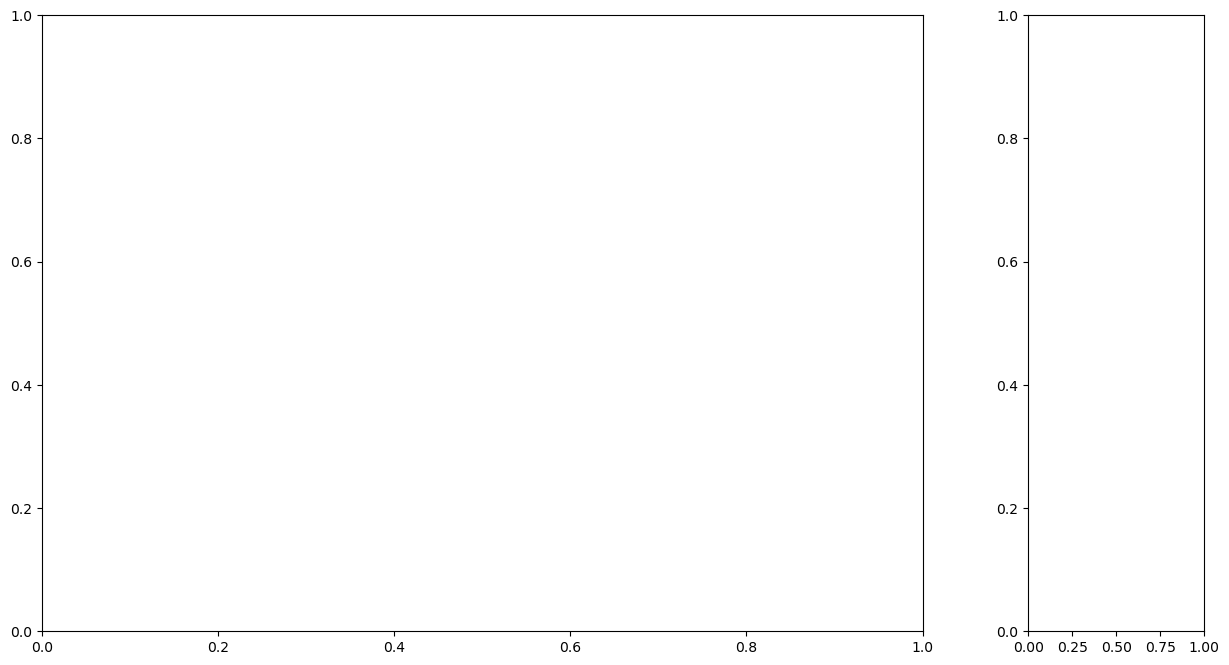

In [57]:
test_FID = FID()
test_FID.name = ["test"]
test_FID.time = loaded_fid.time
test_FID.signal = result_test[:,1, 1, 1]

# ==> Test plausability! shorter T2 makes broader or narrow???

test_FID.plot()

In [39]:
### keys_concentration = np.array(list(concentration_maps.maps.keys()))
### values_concentration = np.stack(list(concentration_maps.maps.values()), axis=0)
### 
### keys_t1 = np.array(list(t1_maps.maps.keys()))
### values_t1 = np.stack(list(t1_maps.maps.values()), axis=0)
### 
### keys_t2 = np.array(list(t2_maps.maps.keys()))
### values_t2 = np.stack(list(t2_maps.maps.values()), axis=0)
### 
### print(f"keys: \n conc: {keys_concentration};\n   t1: {keys_t1};\n   t2: {keys_t2}")
### # -> ok permute (metabolite, x, y, z) that all same alignement

In [38]:
### # Normally: Metabolic Property Map Assembler is used here:
### # (1) Need to collect each map -> maybe with dynamic input: args
### # (2) Need to sort based on refereence = stanadard reference is first element
### # (3) Then need to concatenate all of them?
### 
### 
### # Inverse mapping: for each name in reference order where is it in t1_keys
### concentration_keys = ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']
### t1_keys = ['m-Ins', 'NAA', 'Glu', 'Cr+PCr', 'GPC+PCh', 'Gln']
### t2_keys = ['Glu', 'Gln', 'm-Ins', 'Cr+PCr', 'NAA', 'GPC+PCh']
### 
### # get of each names list the order
### t1_map = {name:i for i, name in enumerate(t1_keys)}
### idx_t1 = [t1_map[name] for name in concentration_keys]
### 
### t2_map = {name:i for i, name in enumerate(t2_keys)}
### idx_t2 = [t2_map[name] for name in concentration_keys]
### 
### print(idx_t1)
### values_t1_sorted = values_t1[idx_t1, ...]
### values_t1_sorted = values_t1_sorted[:, None, ...]
### values_t2_sorted = values_t2[idx_t2, ...]
### values_t2_sorted = values_t2_sorted[:, None, ...]
### # DONT FORGET THE REFERENCE (MAYBE extend dim before!):
### values_concentration_sorted = values_concentration[:, None, ...]
### print(values_t1_sorted.shape)
### print(values_t2_sorted.shape)
### print(values_concentration_sorted.shape)
### np.concatenate([values_t1_sorted, values_t2_sorted, values_concentration_sorted], axis=1).shape
### #values_t1_solted = values_t1[t1_order, ...] 

In [39]:
### # DELETE 
### # GET FID signal shape:
### #    -> check right assignment (right metabolite FID signal to right MAP)
### 
### print(loaded_fid.signal.shape)
### print(type(loaded_fid.signal))
### 
### for signal in fid:
###     print("FID: ", signal.name[0])
### 
### print("-----------")
### 
### # -> multiplying with mask should not be a problem, right?
### for key, value in metabolic_property_map_dict.items():
###     print("Map: ", key, "Value shape: ", value.concentration)

In [40]:
spectral_spatial_model = SpectralSpatialModel(path_cache=configurator.data["path"]["cache"],
                                              block_size=block_size,  # Note, also possible: 1536x10x10x10
                                              TE=TE,
                                              TR=TR,
                                              alpha=alpha,
                                              data_type="complex64",
                                              compute_on_device="cuda",
                                              return_on_device="cpu") # TODO: When doing here cpu next part then cuda has issue!

spectral_spatial_model.add_metabolic_property_maps(metabolic_property_map_dict) # Add map holding multiple MetabolicPropertyMaps (one for each metabolite)
spectral_spatial_model.add_fid(fid)                                             # Add FID (all separate signals summed up)
spectral_spatial_model.add_mask(metabolic_mask.data)                            # Mask of brain
spectral_spatial_model.model_summary()


# a) Output of graph just for final result:
#computational_graph_0 = spectral_spatial_model.assemble_graph()
# b) Output of graph for the individual steps:
computational_graph_0__after_mask, computational_graph_0__after_T1, computational_graph_0__after_T2, computational_graph_0__after_concentration_scaling = spectral_spatial_model.assemble_graph(all_steps_output=True)
computational_graph_0 = computational_graph_0__after_concentration_scaling

[ 21  ][ success ] ---v  (collected several lines)                      
                      Adding the following metabolic property maps to the model:
                      0: Glu
                      1: Gln
                      2: m-Ins
                      3: NAA
                      4: Cr+PCr
                      5: GPC+PCh
                      
[ 22  ][ success ] ---v  (collected several lines)                      
                      Added the following FID signals to the spectral spatial model:
                      0: Glu
                      1: Gln
                      2: m-Ins
                      3: NAA
                      4: Cr+PCr
                      5: GPC+PCh
                      
[ 23  ][  info   ] ---v  (collected several lines)                      
                      Spectral-Spatial-Model Summary:
                       TE          ... 0.0013
                       TR          ... 0.6
                       alpha       ... 45
                  

100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 239.17it/s]


### Investigate indivitual steps of the spectral-spatial model

In [41]:
example_voxel = (40,40,40)
x,y,z = example_voxel

g.add_node(name="Investigate effects on the spectrum",
           text=f"Show T1, T2, concentration effects on the spectrum, thus compute part of graph. Voxel chosen: {example_voxel}.", 
           width=0.5, cluster="GPU cluster")


# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=True, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="28GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=False, protocol="tcp")

client = cluster.client


# 2) Compute intermediate result
Console.start_timer()

### after_mask = computational_graph_0__after_mask[:,x,y,z].compute()
### after_T1 = computational_graph_0__after_T1[:,x,y,z].compute()
### after_T2 = computational_graph_0__after_T2[:,x,y,z].compute()
### after_concentration_scaling = computational_graph_0__after_concentration_scaling[:, x,y,z].compute()

# OPTIONAL WAY: MORE CLEAN
arrays = [
    computational_graph_0__after_mask[:,x,y,z],
    computational_graph_0__after_T1[:,x,y,z],
    computational_graph_0__after_T2[:,x,y,z],
    computational_graph_0__after_concentration_scaling[:, x,y,z],
]

future_results = client.compute(arrays)
after_mask, after_T1, after_T2, after_concentration_scaling = client.gather(future_results)

Console.stop_timer()
# 3) Close client and cluster
cluster.close()

[ 25  ][  info   ] >> Splitting large chunks is activated                                                                  
[ 26  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          


/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 17.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-12-29 18:22:48,275 - distributed.worker - WARNING - Compute Failed
Key:       ('_transform_T1-187ee1745f06dbcdc21723c98f415a8f', 53, 0, 0, 1)
Function:  subgraph_callable-98cd93ff-c161-4056-b006-ba2a7966
args:      (array([[[[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
         ...,
         [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]],

        [[ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
         [ 0.+0.j,  0.+0.j,

ValueError: operands could not be broadcast together with shapes (20, 112, 128, 80) (56, 64, 40)

In [ ]:
test_fid_spectral_spatial = FID()

test_fid_spectral_spatial += FID(signal=after_mask, time=loaded_fid.time, name=[f"after_mask FID [:,{example_voxel[0]},{example_voxel[1]},{example_voxel[2]}]"])
test_fid_spectral_spatial += FID(signal=after_T1, time=loaded_fid.time, name=[f"after_T1 FID [:,{example_voxel[0]},{example_voxel[1]},{example_voxel[2]}]"])
test_fid_spectral_spatial += FID(signal=after_T2, time=loaded_fid.time, name=[f"after_T2 FID [:,{example_voxel[0]},{example_voxel[1]},{example_voxel[2]}]"])
test_fid_spectral_spatial += FID(signal=after_concentration_scaling, time=loaded_fid.time, name=[f"after_concentration_scaling FID [:,{example_voxel[0]},{example_voxel[1]},{example_voxel[2]}]"])


test_fid_spectral_spatial.plot(additional_description="Please note: This are \n actually not the individual signals of a FID. \n This are signals after applying transformations.")

### Compute the whole spectral-spatial model

In [ ]:
### IMPORTANT: ONLY RELECANT FOR MSC Cluster (!!!)

#!conda install -c conda-forge ucx ucx-proc=*=gpu ucx-py
#import dask

# Turn off NVML diagnostics everywhere (scheduler + workers)
#dask.config.set({"distributed.diagnostics.nvml": False})

In [ ]:
g.add_node(name="Compute spectral-spatial model",
           #text=f"To compute the graph of the spatial spectral model.", 
           width=0.5, cluster="GPU cluster")


# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#cluster.start_cpu(number_workers=2, threads_per_worker=10, memory_limit_per_worker="60GB")
# 2) Compute intermediate result
Console.start_timer()
volume_computed = computational_graph_0.compute()
Console.stop_timer()
# 3) Close client and cluster
cluster.close()
# 4) Convert again to dask array
computational_graph_1 = da.from_array(volume_computed, chunks=block_size)

# Sampling model

### Load the coil sensitivity maps

In [39]:
g.add_node(name="Load and prepare coil sensitivity maps", 
           text="Load and prepare coil sensitivity maps. Note: Only HDF5 files are supported at the moment, where img and real is separate. It gets combined to complex number..", 
           cluster="Load and prepare the data",
           title_colour="yellow")


coil_sensitivity_maps_loader = file.CoilSensitivityMaps(configurator=configurator)
coil_sensitivity_maps_loader.load_h5py(keys=["imag", "real"], dtype=np.complex64)

target_size = (32, metabolic_mask.shape[0], metabolic_mask.shape[1], metabolic_mask.shape[2])

g.add_node(name="Interpolate coil sensitivity", text=f"Interpolate coil sensitivity maps to {target_size}", cluster="Interpolation", width=0.5)
coil_sensitivity_maps = coil_sensitivity_maps_loader.interpolate(target_size=target_size, order=2, compute_on_device='cuda', gpu_index=target_gpu_smaller_tasks, return_on_device='cpu') # TODO TODO TODO TODO


[ 34  ][ success ] ---v  (collected several lines)                      
                      Coil Sensitivity Maps:
                       => Could find keys ['imag', 'real'] in the HDF5 file
                       => Loaded and converted maps to complex64
                      
[ 35  ][  info   ] >> Start interpolating coil sensitivity maps                                                            
[ 36  ][ success ] ---v  (collected several lines)                      
                      Interpolated the coil sensitivity maps:
                       => From size: (32, 80, 86, 86) --> (32, 112, 128, 80)
                       => with interpolation order: 2
                       => on device cuda:2 --> and returned on cpu
                      


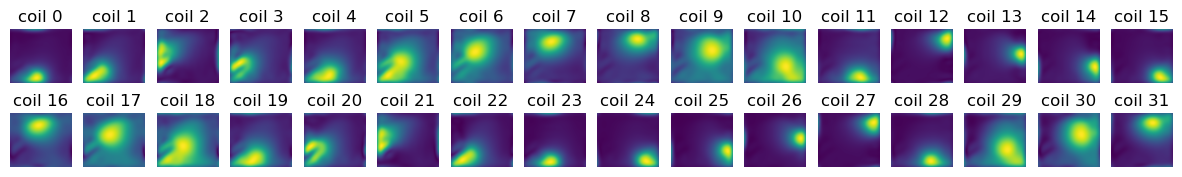

In [40]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=coil_sensitivity_maps.shape[0] // 2,
    figsize=(15, 2)
)

for i, ax in enumerate(axs.flat):
    ax.imshow(np.abs(coil_sensitivity_maps[i, :, :, 40]))
    #ax.imshow(np.abs(coil_sensitivity_maps[i, :, :, 40].get()))
    ax.axis("off")
    ax.set_title(f"coil {i}")

### Create the sampling model & Apply the coil sensitivity maps

In [41]:
text = """ =====================================================================================================
        Step: Create Sampling Model
        
        Description: `To create plain sampling model and then apply the coil sensitivity maps.
        This includes 32 coild sensitivity maps and thus extends the shape from [t,x1,x2,x3] 
        to [coils, t, x1,x2,x3].`
        
            [ ] fix that path cache has no effect!
        """
g.add_node(name="Create Sampling Model",
           text=text, 
           cluster="Create models",
           title_colour="yellow")

# (A) Create the sampling model
block_size_computational_graph_spectral_spatial_model = (int(20), int(112), int(128), int(80))
block_size_coil_sensitivity_maps = (int(20), int(112), int(128), int(80))

sampling_model = SamplingModel(computational_graph_spectral_spatial_model=computational_graph_1,
                               block_size_computational_graph_spectral_spatial_model=block_size_computational_graph_spectral_spatial_model,
                               coil_sensitivity_maps=coil_sensitivity_maps,
                               block_size_coil_sensitivity_maps=block_size_coil_sensitivity_maps,
                               path_cache="This/was/a/real/path/but/still/has/no/effect", # TODO: has no effect! <- seems to have an effect!
                               persist_computational_graph_spectral_spatial_model=False
                               )

# (B) Apply the coil sensitivity maps
# Volume (coil, time, X, Y, Z)
computational_graph_2 = sampling_model.apply_coil_sensitivity_maps(compute_on_device='cuda', return_on_device='cuda')
#computational_graph_3 = sampling_model.coil_combination(volume_with_coil_sensitivity=computational_graph_2, compute_on_device='cuda', return_on_device='cpu')
computational_graph_2

[ 37  ][  info   ] >> Sampling Model: Converting coil_sensitivity_maps <class 'numpy.ndarray'> --> dask Array              
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<


dask.array<mul, shape=(32, 1536, 112, 128, 80), dtype=complex64, chunksize=(20, 20, 112, 128, 80), chunktype=cupy.ndarray>

# Cartesian k-Space & Cropping

In [42]:
crop_center_shape = (64, 64, 40)

g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_3 = sampling_model.cartesian_FFT(volumes_with_coil_sensitivity_maps=computational_graph_2,
                                                     crop_center_shape=crop_center_shape,
                                                     compute_on_device='cuda',  # cuda works with 100_000
                                                     return_on_device='cuda')   # cpu works with 100_000

[ 38  ][ success ] ---v  (collected several lines)                      
                      Performed FFT for:
                       > Coil 1
                       > Coil 2
                       > Coil 3
                       > Coil 4
                       > Coil 5
                       > Coil 6
                       > Coil 7
                       > Coil 8
                       > Coil 9
                       > Coil 10
                       > Coil 11
                       > Coil 12
                       > Coil 13
                       > Coil 14
                       > Coil 15
                       > Coil 16
                       > Coil 17
                       > Coil 18
                       > Coil 19
                       > Coil 20
                       > Coil 21
                       > Coil 22
                       > Coil 23
                       > Coil 24
                       > Coil 25
                       > Coil 26
                       > Coil 27
    

#### <span style="color:red">!!! The following step is just a test regarding selecting the only the desired GPU (not utilise GPU = as currently)</span>

In [43]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

test_gpu = computational_graph_3[0].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

[ 39  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 40  ][  info   ] >> Splitting large chunks is activated                                                                  


Unable to start CUDA Context
Traceback (most recent call last):
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/comm/ucx.py", line 133, in init_once
    cuda_visible_device = get_device_index_and_uuid(
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/diagnostics/nvml.py", line 256, in get_device_index_and_uuid
    device_handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 2914, in nvmlDeviceGetHandleByIndex
    fn = _nvmlGetFunctionPointer("nvmlDeviceGetHandleByIndex_v2")
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 1074, in _nvmlGetFunctionPointer
    raise NVMLError(NVML_ERROR_UNINITIALIZED)
pynvml.NVMLError_Uninitialized: Unini

[ 41  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          
       TOOK 102.458 sec       
[ 42  ][ success ] >> Successfully closed client                                                                           
[ 43  ][ success ] >> Successfully closed cluster                                                                          


# Back to i-Space (IFFT)

In [44]:
g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_4 = sampling_model.cartesian_IFFT(volumes_cartesian_k_space=computational_graph_3,
                                                      compute_on_device='cuda',   # cuda work with 100_000
                                                      return_on_device='cuda')    # cpu work with 100_000

(!) Node already exists: Cartesian Fourier Transformation
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy arr

In [45]:
interpolate_sensitivity_maps = (32,) + crop_center_shape

g.add_node(name="Interpolate coil sensitivity (ifft)", text=f"Interpolate coil sensitivity maps to {interpolate_sensitivity_maps}. For Coil combination after IFFT.", cluster="Interpolation", width=0.5)

coil_sensitivity_maps_resized = coil_sensitivity_maps_loader.interpolate(target_size=interpolate_sensitivity_maps, order=2, compute_on_device='cuda', gpu_index=target_gpu_smaller_tasks, return_on_device='cuda') # TODO TODO TODO TODO

[ 44  ][  info   ] >> Start interpolating coil sensitivity maps                                                            
[ 45  ][ success ] ---v  (collected several lines)                      
                      Interpolated the coil sensitivity maps:
                       => From size: (32, 112, 128, 80) --> (32, 64, 64, 40)
                       => with interpolation order: 2
                       => on device cuda:2 --> and returned on cuda
                      


In [46]:
computational_graph_4

[dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, 

In [47]:
import cupy as cp
import dask
import dask.array as da


graphs_da = da.stack([da.asarray(g) for g in computational_graph_4], axis=0)   # (32,1536,64,64,40)
coils_da  = da.stack([da.asarray(c) for c in coil_sensitivity_maps_resized], axis=0)  # (32,64,64,40)

# IMPORTANT: make coils broadcast over the 1536 dimension
coils_da_b = coils_da[:, None, ...]  # (32,1,64,64,40)

num_da = da.sum(graphs_da * da.conj(coils_da_b), axis=0)   # -> (1536,64,64,40)
den_da = da.sum(da.absolute(coils_da) ** 2, axis=0)        # -> (64,64,40)

/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/cupy/_manipulation/join.py:60: PerformanceWarning: The device where the array resides (2) is different from the current device (0). Peer access has been activated automatically.
  return _core.concatenate_method(tup, axis, out, dtype, casting)


In [48]:
text = f""" =====================================================================================================
        Step: Compute the forward process
        
        Description: `This computes the sampling model and also includes a forward process to check the data.`
            [x] 1. Bring to k-space (thus FFT to dimensions 1,2,3 excluding 0)
            [x] 2. Crop the center to {crop_center_shape}
            [x] 3. IFFT back to image space
            [x] 4. Interpolate coil sensitivity maps to {crop_center_shape}
            [x] 5. Could combination with resized coil sensitivity maps
        
        """

g.add_node(name="Compute the forward process",
           text=text,
           cluster="GPU cluster",
           title_colour="green")


# Start cluster again!
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

num, den = dask.compute(num_da, den_da) 

num = cp.asnumpy(num) if isinstance(num, cp.ndarray) else num
den = cp.asnumpy(den) if isinstance(den, cp.ndarray) else den

Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()
# 4) Convert again to dask array
computational_graph_1 = da.from_array(volume_computed, chunks=block_size)

[ 46  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 47  ][  info   ] >> Splitting large chunks is activated                                                                  


Unable to start CUDA Context
Traceback (most recent call last):
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/comm/ucx.py", line 133, in init_once
    cuda_visible_device = get_device_index_and_uuid(
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/diagnostics/nvml.py", line 256, in get_device_index_and_uuid
    device_handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 2914, in nvmlDeviceGetHandleByIndex
    fn = _nvmlGetFunctionPointer("nvmlDeviceGetHandleByIndex_v2")
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 1074, in _nvmlGetFunctionPointer
    raise NVMLError(NVML_ERROR_UNINITIALIZED)
pynvml.NVMLError_Uninitialized: Unini

[ 48  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          
       TOOK 121.511 sec       
[ 49  ][ success ] >> Successfully closed client                                                                           
[ 50  ][ success ] >> Successfully closed cluster                                                                          


#### <span style="color:red">Signal height is too much?</span>

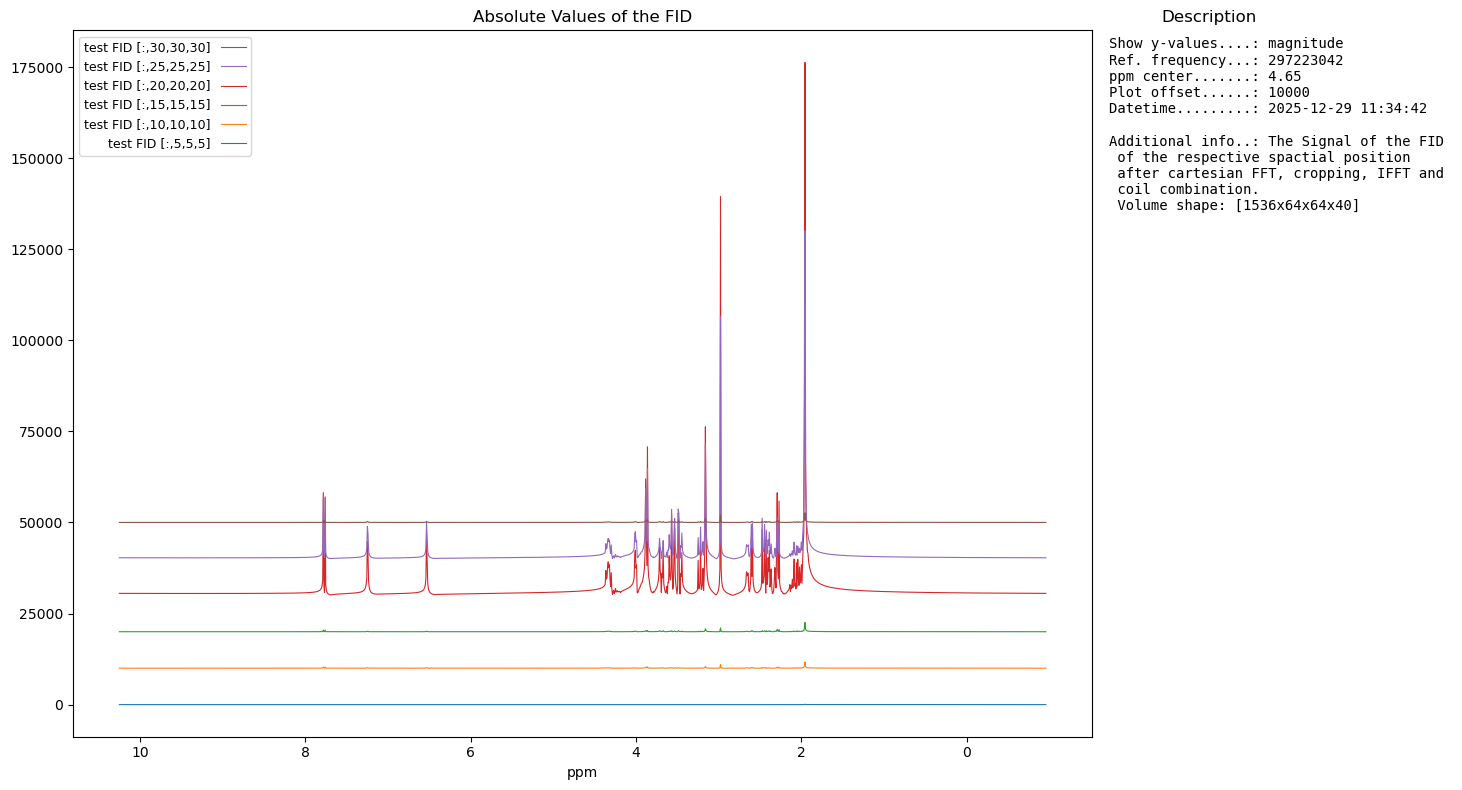

In [49]:
result = num/den
result.shape

test_fid = FID()

for i in range(5,35,5):
    test_fid += FID(
        signal=result[:,i,i,i], 
        time=loaded_fid.time, 
        name=[f"test FID [:,{i},{i},{i}]"])

#test_fid = FID(signal=result[:,20,20,20], time=loaded_fid.time, name=["test FID 1"])
test_fid.plot(additional_description="The Signal of the FID \n of the respective spactial position \n after cartesian FFT, cropping, IFFT and \n coil combination. \n Volume shape: [1536x64x64x40]", plot_offset=10000)

In [50]:
#result

In [51]:
#plt.plot(result[:, 20,20,20].compute())

#result.shape

In [52]:
g.create()
g.save("cartesian__easy_graph_test_2")

In [53]:
import dask, distributed, bokeh
import dask_labextension

print("dask:", dask.__version__)
print("distributed:", distributed.__version__)
print("bokeh:", bokeh.__version__)
print("dask_labextension:", dask_labextension.__version__)


dask: 2023.9.2
distributed: 2023.9.2
bokeh: 3.2.2
dask_labextension: 7.0.0


In [54]:
!jupyter lab --version

4.5.0
